In [1]:
import pandas as pd
from fitter import Fitter, get_common_distributions
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Data Exploration (restaurant 1)


In [90]:
order_df_raw = pd.read_csv('restaurant-1-orders.csv')
order_df_raw.head(10)
# order_df_raw.tail()
# order_df_raw.shape
# order_df_raw.columns
# order_df_raw['Restaurant ID'].unique()
# order_df_raw['Order Date'].unique()

,Order Number,Order Date,Item Name,Quantity,Product Price,Total products
0,16118,03/08/2019 20:25,Plain Papadum,2,0.80,6
1,16118,03/08/2019 20:25,King Prawn Balti,1,12.95,6
2,16118,03/08/2019 20:25,Garlic Naan,1,2.95,6
3,16118,03/08/2019 20:25,Mushroom Rice,1,3.95,6
4,16118,03/08/2019 20:25,Paneer Tikka Masala,1,8.95,6
5,16118,03/08/2019 20:25,Mango Chutney,1,0.50,6
6,16117,03/08/2019 20:17,Plain Naan,1,2.60,7
7,16117,03/08/2019 20:17,Mushroom Rice,1,3.95,7
8,16117,03/08/2019 20:17,Tandoori Chicken (1/4),1,4.95,7
9,16117,03/08/2019 20:17,Vindaloo - Lamb,1,7.95,7


## Check for shifts (check out the time distribution of orders)

In [67]:
# Convert "Order Date" column to 24-hour integer format and get array

def time_to_integer(time_str):
    time = datetime.strptime(time_str, "%d/%m/%Y %H:%M").time()
    return int(time.hour * 100 + time.minute)

order_date_arr = order_df_raw['Order Date'].apply(time_to_integer).to_numpy()
order_date_arr

array([2025, 2025, 2025, ..., 1318, 1904, 1729], dtype=int64)

(array([5.000e+00, 6.000e+00, 2.400e+01, 0.000e+00, 0.000e+00, 8.000e+00,
        3.000e+00, 0.000e+00, 1.600e+01, 1.200e+01, 3.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        6.000e+00, 4.000e+00, 0.000e+00, 4.000e+00, 4.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.600e+01, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 9.000e+00, 7.000e+00,
        3.500e+01, 0.000e+00, 0.000e+00, 5.000e+00, 3.900e+01, 3.100e+01,
        0.000e+00, 2.800e+01, 5.200e+01, 8.200e+01, 0.000e+00, 8.000e+00,
        1.920e+02, 2.460e+02, 7.200e+01, 1.600e+01, 5.300e+02, 5.510e+02,
        3.230e+02, 0.000e+00, 4.370e+02, 4.270e+02, 3.660e+02, 0.000e+00,
        6.500e+01, 2.240e+02, 1.740e+02, 4.400e+01, 1.800e+01, 1.730e+02,
        2.400e+02, 1.420e+02, 0.000e+00, 2.670e+02, 7.320e+02, 1.335e+03,
        0.000e+00, 8.800e+02, 3.813e+03, 6.181e+03, 1.486e+03, 2.610e+02,
        8.228e+03, 8.661e+03, 5.281e+0

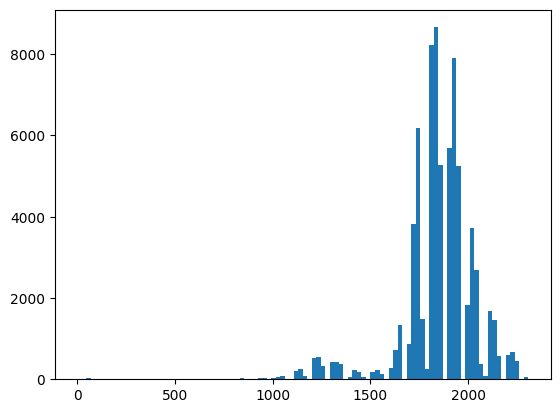

In [78]:
plt.hist(order_date_arr, bins=100)

Insights:
1. Unclear shifts in a day
2. Interval between orders (large intervals) from different shifts in a day(if exists) would not be impactful -> each day can be considered as one shift -> Intervals between orders from different days should not be considered.

## Check if there is more than 1 server (same order date different order number).

In [38]:
# number of unique 'Order Number' for each 'Order Date'
grouped = order_df_raw.groupby('Order Date')['Order Number'].nunique()
grouped

Order Date
01/01/2017 17:31    1
01/01/2017 17:38    1
01/01/2017 17:51    1
01/01/2017 18:20    1
01/01/2017 18:28    1
                   ..
31/12/2018 19:37    1
31/12/2018 20:14    1
31/12/2018 20:54    1
31/12/2018 21:13    1
31/12/2018 21:56    1
Name: Order Number, Length: 13081, dtype: int64

In [69]:
# maximum number of unique 'Order Number' for an 'Order Date'
max_unique = max(grouped)
max_unique

3

(array([  2.,   0.,   2.,   0.,   2.,  22.,  98., 125.,  50.,   8.]),
 array([1131. , 1231.5, 1332. , 1432.5, 1533. , 1633.5, 1734. , 1834.5,
        1935. , 2035.5, 2136. ]),
 <BarContainer object of 10 artists>)

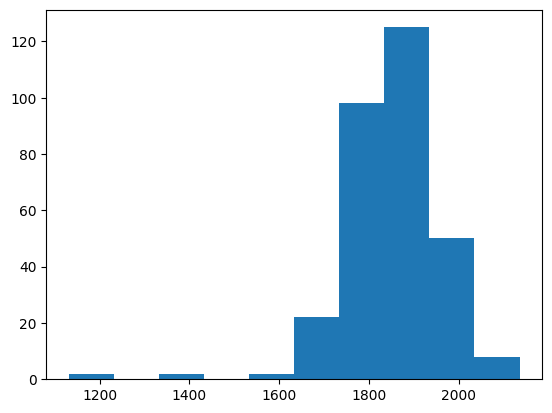

In [76]:
# 'Order Date' distribution with more than 1 unique 'Order Number'
above1arr = []
for item in grouped.items():
    if item[1] > 1:
        above1arr.append(time_to_integer(item[0]))

plt.hist(above1arr)

[2001, 1708, 1902, 1922, 1853, 1902, 1646]

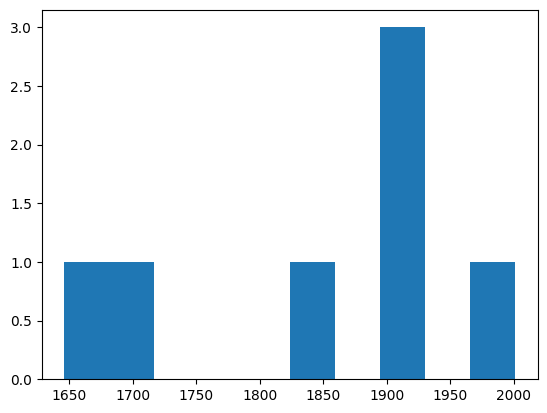

In [75]:
# 'Order Date' distribution with max_unique unique 'Order Number'
above1arr = []
for item in grouped.items():
    if item[1] == max_unique:
        above1arr.append(time_to_integer(item[0]))

plt.hist(above1arr)
above1arr

Insights:
1. Restaurant 1 is able to handle at least 3 requests at a single time (assuming no machinery faults).

## Explore the distribution of intervals between orders

In [93]:
# split 'Order Date' by date

order_date_df = order_df_raw[['Order Date']]
# convert 'Order Date' to date
order_date_df['Order Date'] = order_date_df['Order Date'].apply(lambda x: datetime.strptime(x, "%d/%m/%Y %H:%M"))
# add 'date' column
order_date_df['date'] = order_date_df['Order Date'].apply(lambda x: x.date())
order_date_series_by_date = order_date_df.groupby('date')['Order Date'].apply(lambda x: np.unique(np.array(x)))
order_date_dict_by_date = order_date_series_by_date.to_dict()

C:\Users\zzyy\AppData\Local\Temp\ipykernel_11512\3727675906.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_date_df['Order Date'] = order_date_df['Order Date'].apply(lambda x: datetime.strptime(x, "%d/%m/%Y %H:%M"))
C:\Users\zzyy\AppData\Local\Temp\ipykernel_11512\3727675906.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_date_df['date'] = order_date_df['Order Date'].apply(lambda x: x.date())


In [94]:
# get intervals for each day

intervals_dict_by_date = {}
for k, v in order_date_dict_by_date.items():
    intervals_dict_by_date[k] = ((v[1:] - v[:-1]) / (1000000000*60)).astype('float64')

In [97]:
# merge all intervals

intervals_merged_list = []
for k, v in intervals_dict_by_date.items():
    intervals_merged_list.extend(v)

(array([1.1005e+04, 4.9800e+02, 2.3000e+02, 1.1000e+02, 1.0000e+01,
        4.0000e+00, 2.0000e+00, 5.0000e+00, 4.0000e+00, 6.0000e+00]),
 array([1.000e+00, 1.056e+02, 2.102e+02, 3.148e+02, 4.194e+02, 5.240e+02,
        6.286e+02, 7.332e+02, 8.378e+02, 9.424e+02, 1.047e+03]),
 <BarContainer object of 10 artists>)

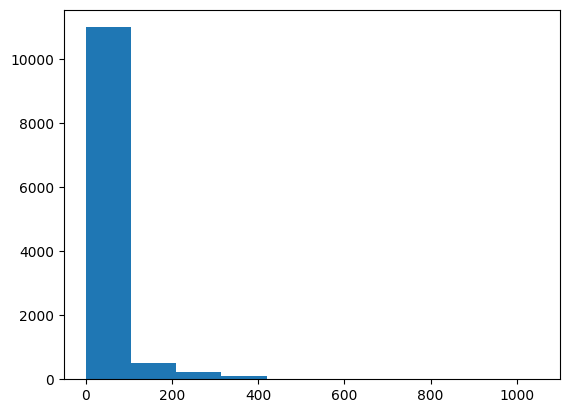

In [98]:
plt.hist(intervals_merged_list)

{'lognorm': {'s': 1.4738752714840349, 'loc': 0.5072848265329463, 'scale': 13.427557349367415}}


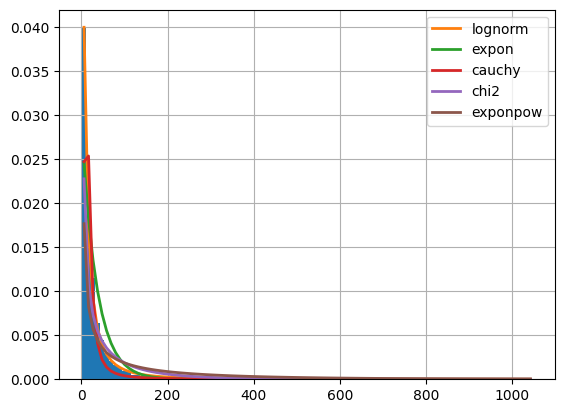

In [99]:
f = Fitter(intervals_merged_list, distributions=get_common_distributions())
f.fit()
f.summary()
print(f.get_best(method="sumsquare_error"))
